In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

## Load data

In [10]:
x1, x2, y = np.loadtxt('non_linearly_separable.txt', skiprows=1, unpack=True)

## Neural Network

In [11]:
class OnehiddenNN:
    
    def __init__(self, n_hidden_nodes, n_iters=1000,learning_rate=0.01):
        self.n_hidden_nodes=torch.tensor(n_hidden_nodes)
        self.lr=torch.tensor(learning_rate)
        self.n_iters=torch.tensor(n_iters)
        self.w1=None
        self.w2=None
    
    
    def sigmoid(self, z):
        return 1 / (1 + torch.exp(-z))
    
    def softmax(self, logits):
        exponentials = torch.exp(logits)
        return exponentials / torch.sum(exponentials, axis=1).view(-1, 1)
    
    def prepend_bias(self, X):
        bias=torch.ones(X.shape[0],1)
        return torch.cat((bias, X), 1)
    
    def train(self, X_train, Y_train, X_test, Y_test):
        n_input_variables = torch.tensor(X_train.shape[1])
        n_classes = torch.tensor(Y_train.shape[1])
        self.w1, self.w2 = self.initialize_weights(n_input_variables, n_classes)
        for n_iters in range(self.n_iters):
            y_hat, h = self.forward(X_train)
            w1_gradient, w2_gradient = self.back(X_train, Y_train, y_hat, h)
            self.w1 = self.w1 - (w1_gradient * self.lr)
            self.w2 = self.w2 - (w2_gradient * self.lr)
            self.report(n_iters, X_train, Y_train, X_test, Y_test)
    
    def initialize_weights(self, n_input_variables, n_classes):
        w1_rows = n_input_variables + 1
        self.w1 = torch.randn(w1_rows, self.n_hidden_nodes) * torch.sqrt(1 / w1_rows)
        w2_rows = self.n_hidden_nodes + 1
        self.w2 = torch.randn(w2_rows, n_classes) * torch.sqrt(1 / w2_rows)
        return (self.w1, self.w2)
        
    def forward(self, X):
        h = self.sigmoid(torch.matmul(self.prepend_bias(X), self.w1))
        y_hat = self.softmax(torch.matmul(self.prepend_bias(h), self.w2))
        return (y_hat, h)
    
    def loss(self, Y, y_hat):
        return -torch.sum(Y * torch.log(y_hat)+(1-Y)* torch.log(1-y_hat))/ Y.shape[0]
    
    def sigmoid_gradient(self, sigmoid):
        return torch.multiply(sigmoid, (1 - sigmoid))
    
    def back(self, X, Y, y_hat, h):
        dw2 = torch.matmul(self.prepend_bias(h).T, (y_hat - Y)) / X.shape[0]
        dh  = torch.matmul(y_hat - Y, self.w2[1:].T)
        da  = dh * self.sigmoid_gradient(h)
        dw1 = torch.matmul(self.prepend_bias(X).T, da)/X.shape[0]
        return (dw1, dw2)
    
    def classify(self, X):
        y_hat, _ = self.forward(X)
        labels = torch.argmax(y_hat, axis=1)
        return labels.view(-1, 1)
    
    def report(self, iteration, X_train, Y_train, X_test, Y_test):
        y_hat, _ = self.forward(X_train)
        training_loss = self.loss(Y_train, y_hat)
        classifications = self.classify(X_test)
        accuracy = torch.mean(torch.eq(classifications,Y_test).to(torch.float32)) * 100.0
        if iteration % 5000 == 0:
            print("Iteration: %5d, Loss: %.8f, Accuracy: %.2f%%" %(iteration, training_loss, accuracy))
    
    def mesh(self,values):
        range = values.max() - values.min()
        padding_percent = 5
        padding = range * padding_percent * 0.01
        resolution = 1000
        interval = (range + 2 * range * padding) / resolution
        return torch.arange(values.min() - padding, values.max() + padding, interval)


    def plot_boundary(self,points):
        print("Calculating boundary...")
        x_mesh = self.mesh(points[:, 0])
        y_mesh = self.mesh(points[:, 1])
        grid_x, grid_y = torch.meshgrid(x_mesh, y_mesh)
        grid_x_n=grid_x.numpy()
        grid_y_n=grid_y.numpy()
        grid = np.c_[grid_x_n.ravel(), grid_y_n.ravel()]
        grid=torch.tensor(grid)
        classifications = self.classify(grid).view(grid_x.shape)
        BLUE_AND_GREEN = ListedColormap(['#BBBBFF', '#BBFFBB'])
        plt.contourf(grid_x, grid_y, classifications, cmap=BLUE_AND_GREEN)


    def plot_data_by_label(self,input_variables, labels, label_selector, symbol):
        points = input_variables[(labels == label_selector).flatten()]
        plt.plot(points[:, 0], points[:, 1], symbol, markersize=4)
        
    #為了Plot Model所定義numpy版本的forward
    def forward_np(self, X):
        w1=self.w1.numpy()
        w1_64 = np.float64(w1)
        h = 1 / (1 + np.exp(-(np.matmul(np.insert(X, 0, 1, axis=1), w1_64))))
        w2=self.w2.numpy()
        w2_64=np.float64(w2)
        exponentials = np.exp(np.matmul(np.insert(h, 0, 1, axis=1), w2_64))
        y_hat = exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)
        return (y_hat, h)

In [12]:
def one_hot_encode(Y):
    n_labels = Y.shape[0]
    result = torch.zeros((n_labels, 2))
    for i in range(n_labels):
        result[i][Y[i]] = 1
    return result

## Model Performance

In [156]:
x_train = x_test = np.column_stack((x1, x2))
Y_train_unencoded = y_test = y.astype(int).reshape(-1, 1)
Y_train = one_hot_encode(Y_train_unencoded)

X_train = torch.from_numpy(x_train).to(torch.float32) # convert to tensor float32
X_test = torch.from_numpy(x_test).to(torch.float32)
Y_test = torch.from_numpy(y_test).to(torch.float32) 

NN = OnehiddenNN(n_hidden_nodes=10,learning_rate=0.1, n_iters=100000)
NN.train(X_train, Y_train, X_test, Y_test)

Iteration:     0, Loss: 1.67036331, Accuracy: 36.00%
Iteration:  5000, Loss: 1.08186078, Accuracy: 74.00%
Iteration: 10000, Loss: 0.90981263, Accuracy: 79.00%
Iteration: 15000, Loss: 0.60023087, Accuracy: 91.33%
Iteration: 20000, Loss: 0.49971101, Accuracy: 94.33%
Iteration: 25000, Loss: 0.46759063, Accuracy: 94.00%
Iteration: 30000, Loss: 0.45452443, Accuracy: 93.67%
Iteration: 35000, Loss: 0.44749466, Accuracy: 93.67%
Iteration: 40000, Loss: 0.44184825, Accuracy: 93.67%
Iteration: 45000, Loss: 0.43495998, Accuracy: 93.67%
Iteration: 50000, Loss: 0.42510095, Accuracy: 94.00%
Iteration: 55000, Loss: 0.41238463, Accuracy: 94.00%
Iteration: 60000, Loss: 0.39742273, Accuracy: 93.67%
Iteration: 65000, Loss: 0.37917668, Accuracy: 94.33%
Iteration: 70000, Loss: 0.35605228, Accuracy: 95.00%
Iteration: 75000, Loss: 0.32879823, Accuracy: 95.67%
Iteration: 80000, Loss: 0.30190134, Accuracy: 96.00%
Iteration: 85000, Loss: 0.28070283, Accuracy: 97.00%
Iteration: 90000, Loss: 0.26564795, Accuracy: 

## Plot Decision Boundary

Calculating boundary...


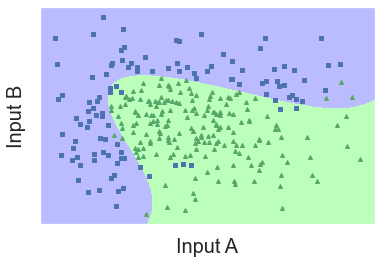

In [158]:
NN.plot_boundary(X_train)
NN.plot_data_by_label(X_train, Y_train_unencoded, 0, 'bs')
NN.plot_data_by_label(X_train, Y_train_unencoded, 1, 'g^')
plt.gca().axes.set_xlabel("Input A", fontsize=20)
plt.gca().axes.set_ylabel("Input B", fontsize=20)
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

## Plot Model

/var/folders/9_/gr09sxx135g1s84jn44jfld80000gn/T/ipykernel_85440/3647102634.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure().gca(projection="3d")
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.00158213 0.00163147 0.00168232 ... 0.00290663 0.00302819 0.00315445]


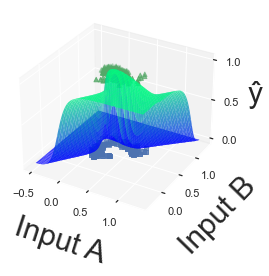

In [159]:
sns.set(rc={"axes.facecolor": "white", "figure.facecolor": "white"})
ax = plt.figure().gca(projection="3d")
ax.set_zticks([0, 0.5, 1])
ax.set_xlabel("Input A", labelpad=15, fontsize=30)
ax.set_ylabel("Input B", labelpad=15, fontsize=30)
ax.set_zlabel("ŷ", labelpad=5, fontsize=30)

blue_squares = x_train[(Y_train_unencoded == 0).flatten()]
ax.scatter(blue_squares[:, 0], blue_squares[:, 1], 0, c='b', marker='s')
green_triangles = x_train[(Y_train_unencoded == 1).flatten()]
ax.scatter(green_triangles[:, 0], green_triangles[:, 1], 1, c='g', marker='^')

MARGIN = 0.5
MESH_SIZE = 1000
x, y = np.meshgrid(np.linspace(x1.min() - MARGIN, x1.max() + MARGIN, MESH_SIZE),
                   np.linspace(x2.min() - MARGIN, x2.max() + MARGIN, MESH_SIZE))
grid = zip(np.ravel(x), np.ravel(y))
forwards = [NN.forward_np(np.column_stack(([i], [j]))) for i, j in grid]
print(forwards)
z = np.array([y_hat for y_hat, h in forwards])[:, 0, 1]
print(z)
z = z.reshape((MESH_SIZE, MESH_SIZE))
ax.plot_surface(x, y, z, alpha=0.75, cmap=cm.winter,
                linewidth=0, antialiased=True)
plt.show()